## Response function for LISA

The response function of a detector tells us how a such a detector reacts to a passing GW from a generic direction. 

In [2]:
# Import the packages needed
import numpy as np
from numpy import pi, sin, cos, sqrt, sinc
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from multiprocessing.pool import ThreadPool as Pool

from tqdm import tqdm


#### LISA fundamental quantities


In [3]:
L = 2.5e9 #m
f_star = 1e-2 #Hz

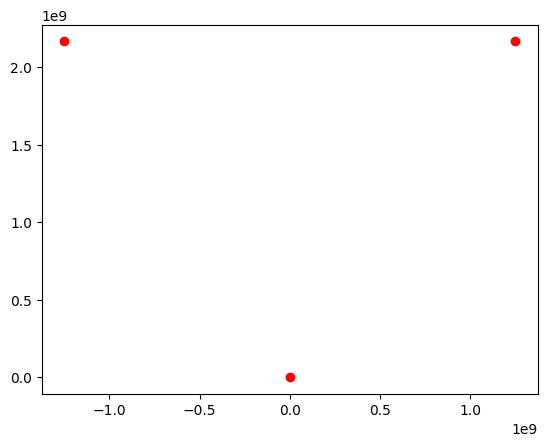

In [4]:
xA = L*np.array([0, 0, 0])
xB = L*np.array([0.5, np.sqrt(3)/2, 0])
xC = L*np.array([-0.5, np.sqrt(3)/2, 0])

plt.plot(xA[0], xA[1], 'ro')
plt.plot(xB[0], xB[1], 'ro')
plt.plot(xC[0], xC[1], 'ro')


### Polarization

The next step consists in evaluating the polarization tensors for a Gravitational Wave (GW) coming from a direction forming angle $\theta$ with the $\hat{z}$-axis and $\phi$ with the $\hat{x}$-axis. 

For a GW coming from a generic $\hat{n}$ direction, we have that

\begin{equation*}
\begin{cases}
\hat{n} = (\sin\theta \cos\phi, \sin\theta\sin\phi, \cos\theta)\\
\hat{u} = (\cos\theta\cos\phi, \cos\theta\sin\phi, -\sin\theta)\\
\hat{v} = (\sin\phi, -\cos\phi,0)
\end{cases}
\end{equation*}
and
\begin{equation*}
\mathbf{e}^+ = \hat{u}\otimes\hat{u} - \hat{v}\otimes\hat{v} \qquad
\mathbf{e}^\times = \hat{u}\otimes\hat{v} + \hat{v}\otimes\hat{u} \,.
\end{equation*}


In [5]:
def uvOmega_basis(theta, phi):
    # Construct each component as a 2D array first
    u0 = np.cos(theta) * np.cos(phi)
    u1 = np.cos(theta) * np.sin(phi)
    u2 = -np.sin(theta)

    v0 = -np.sin(phi)
    v1 = np.cos(phi)
    v2 = np.zeros_like(phi)  # Ensures v has the same shape as u and Omega

    Omega0 = np.sin(theta) * np.cos(phi)
    Omega1 = np.sin(theta) * np.sin(phi)
    Omega2 = np.cos(theta)

    # Now, stack the components along a new axis to create 3D arrays
    u = np.stack((u0, u1, u2), axis=0)
    v = np.stack((v0, v1, v2), axis=0)
    Omega = np.stack((Omega0, Omega1, Omega2), axis=0)

    return u, v, Omega

def m_n_Omega_basis(theta, phi, psi):
    u, v, Omega = uvOmega_basis(theta, phi)
    m = u*np.cos(psi) + v*np.sin(psi)
    n = -u*np.sin(psi) + v*np.cos(psi)
    return m, n, Omega

def Omega(theta, phi):
    return uvOmega_basis(theta, phi)[2]

def e_pol(theta, phi, psi): #polarization tensors    
    m, n, Omega = m_n_Omega_basis(theta, phi, psi)
    e_plus = np.einsum('iab,jab->ijab', m, m)- np.einsum('iab,jab->ijab', n, n)
    e_cross = np.einsum('iab,jab->ijab',m, n) + np.einsum('iab,jab->ijab',n, m)
    e_x = np.einsum('iab,jab->ijab',m, Omega) + np.einsum('iab,jab->ijab',Omega, m)
    e_y = np.einsum('iab,jab->ijab',n, Omega) + np.einsum('iab,jab->ijab',Omega, n)
    e_b = np.einsum('iab,jab->ijab',m,m) + np.einsum('iab,jab->ijab',n,n)
    e_l = sqrt(2)*(np.einsum('iab,jab->ijab',Omega, Omega))
    return e_plus, e_cross, e_x, e_y, e_b, e_l


In [6]:
# Verify the orthogonality condition

theta = np.linspace(0, pi, 100)
phi = np.linspace(0, 2*pi, 100)
theta, phi = np.meshgrid(theta, phi)
psi = 0

vec = m_n_Omega_basis(theta, phi, psi)
e = e_pol(theta, phi, 0) 

e_plus_00 = e[0][0,0]
e_cross_00 = e[1][0,0]

print(np.einsum('ij, ij ->', e_plus_00, e_cross_00))

-8.171241461241152e-14


## LISA Response function
### Step 1


In [7]:
#LISA arms

def rot_axis(vector, rotation_angle, rotation_axis):
    rotation_axis = rotation_axis/np.linalg.norm(rotation_axis)
    rotation = R.from_rotvec(rotation_axis * rotation_angle)
    return rotation.apply(vector)


def LISA():
    Rsolarsys = 1.5e11 #m
    alpha = 0 # positional angle of the earth in the solar system
    #additional tilt angle of the LISA constellation (lisa stays in a plane not perpedicular to the earth orbit around the sun
    tilt = np.deg2rad(20)
    
    LISA_c = np.array([np.cos(alpha), np.sin(alpha), 0.])*Rsolarsys
    LISAarm = 2.5e9 #m
    first = np.array([1., 0., 0.])
    second = np.array([0., 1., 0.])
  
    ### These are the positions of the 3 detectors
    LISA1     = LISA_c + LISAarm *(-.5*first -0.28867513*second) 
    LISA2     = LISA_c + LISAarm *(+.5*first -0.28867513*second)
    LISA3     = LISA_c + LISAarm *(+0.57735027*second)

    ### And these are the arms
    LISAarm1 = LISA1 - LISA2
    LISAarm2 = LISA2 - LISA3
    LISAarm3 = LISA3 - LISA1
    
    ### unit vectors for the arms
    LISAarm1_ = LISAarm1 / np.linalg.norm(LISAarm1)
    LISAarm2_ = LISAarm2 / np.linalg.norm(LISAarm2)
    LISAarm3_ = LISAarm3 / np.linalg.norm(LISAarm3)
    
    #rotate the arms on a plane inclinated 
    tilt = np.deg2rad(30) #angle 
    LISAarm1_ = np.array(rot_axis(LISAarm1_, tilt, LISA_c))
    LISAarm2_ = np.array(rot_axis(LISAarm2_, tilt, LISA_c))
    LISAarm3_ = np.array(rot_axis(LISAarm3_, tilt, LISA_c))
    
    return LISA_c, LISA1, LISA2, LISA3, LISAarm1_, LISAarm2_, LISAarm3_, LISAarm

def LISA1():
    LISA_c, LISA1, LISA2, LISA3, LISAarm1_, LISAarm2_, LISAarm3_, LISAarm = LISA()
    return LISA1, LISAarm1_, LISAarm3_, LISAarm, "LISA 1"

def LISA2():
    LISA_c, LISA1, LISA2, LISA3, LISAarm1_, LISAarm2_, LISAarm3_, LISAarm = LISA()
    return LISA2, LISAarm2_, LISAarm1_, LISAarm, "LISA 2"

def LISA3():
    LISA_c, LISA1, LISA2, LISA3, LISAarm1_, LISAarm2_, LISAarm3_, LISAarm = LISA()
    return LISA3, LISAarm3_, LISAarm2_, LISAarm, "LISA 3"

def channel(det):
    if det=='AB':
        return LISA1()
    elif det=='BC':
        return LISA2()
    elif det=='CA':
        return LISA3()
    

def contraction(det, theta, phi, psi):
    e = e_pol(theta, phi, psi)
    LISAc, LISAarm1, LISAarm2, LISAarmL, name = channel(det)
    p = np.einsum('ijab,i,j->ab', e[0], LISAarm1, LISAarm2) #e_plus
    c = np.einsum('ijab,i,j->ab', e[1], LISAarm1, LISAarm2) #e_cross
    x = np.einsum('ijab,i,j->ab', e[2], LISAarm1, LISAarm2) #e_x
    y = np.einsum('ijab,i,j->ab', e[3], LISAarm1, LISAarm2) #e_y
    b = np.einsum('ijab,i,j->ab', e[4], LISAarm1, LISAarm2) #e_b
    l = np.einsum('ijab,i,j->ab', e[5], LISAarm1, LISAarm2) #e_l
    return p, c, x, y, b, l

    
    
contr = contraction('AB', theta, phi, 0)


### Step 2
Evaluate the Transfer function
\begin{equation*}
\mathcal{T}(f,\hat{l}_{AB},\hat{n})=\frac{1}{2}\left[e^{ -\pi i f L (1+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1+\hat{k}\cdot \hat{l}_{AB})\right)+ e^{ -\pi i f L (3+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1-\hat{k}\cdot \hat{l}_{AB})\right)\right]
\end{equation*}



(1000, 100, 100)


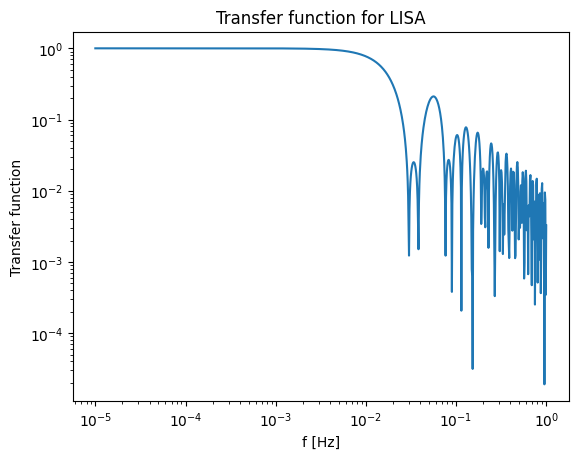

In [8]:
# Build the transfer function

c = 3e8 #m/s

def arm(det):
    LISA2, LISAarm2, LISAarm1, LISAarm, name = channel(det)
    return LISAarm2

def transfer_function(L, e, f, theta, phi, psi):
    #transfer function for LISA
    omega = - m_n_Omega_basis(theta, phi, psi)[2]
    #print(omega.shape)
    l = e
    #print(l.shape)
    exp1 = np.exp(-1j*pi*f*L/c*(1+np.einsum('iab,i->ab', omega, l)))
    exp3 = np.exp(1j*pi*f*L/c*(3+np.einsum('iab,i->ab', omega, l)))
    sinc1 = np.sinc(pi*f*L/c*(1+np.einsum('iab,i->ab', omega, l)))
    sinc3 = np.sinc(pi*f*L/c*(1-np.einsum('iab,i->ab', omega, l)))
    return 0.5*(exp1*sinc1 + exp3*sinc3)



def get_tf(f, which_det, theta, phi, psi):
    c, u, v, l, det_name = channel(which_det)
    tf = transfer_function(l, u, f, theta, phi, psi)
    return tf

tf= []

f = np.logspace(-5, 0, 1000)

for i in range(len(f)):
    tf.append(get_tf(f[i], 'AB', theta, phi, 0))
    #tf_av.append(get_average_tf(f[i], 'AB', 0))


tf = np.array(tf)

print(tf.shape)

plt.loglog(f, np.abs(tf[:, 0,0]))
plt.xlabel('f [Hz]')
plt.ylabel('Transfer function')
plt.title('Transfer function for LISA')
plt.show()




The transfer function is expected to be important only at frequencies higher than the detector's fundamental one ($f\gg f_*$). In the opposite limit it should be unity.

### Step 3
Evaluate the response function in the range $f \in [10^{-5},1]$. 


\begin{equation*}
    \mathcal{R}_{AA'}(f) = \int \frac{d\Omega_{\vec {k}}}{4 \pi} \left[ \mathcal{R}_A^+(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^+}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n}) + \mathcal{R}_A^{\times}(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^{\times}}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n})\right]\,,
\end{equation*}
with
\begin{equation*}
\mathcal{R}_A^P(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}) = \frac{1}{2} e^{-i2\pi f \hat{n}\cdot\vec{x}_A/c} \left[\mathcal{T}(f,\hat{l}_{AB},\hat{n})-\mathcal{T}(f,\hat{l}_{AC},\hat{n})  \right]
\end{equation*}


In [9]:
#  # questa sarebbe la normale definizione di apf

def D_tensor(e1, e2, f, theta, phi, psi): #detector tensor in the small antenna limit
    tf1 = transfer_function(L, e1, f, theta, phi, psi)
    tf2 = transfer_function(L, e2, f, theta, phi, psi)
    out1 = np.einsum('i,j-> ij',e1, e1)
    out2 = np.einsum('i,j-> ij',e2, e2)
    p1 = np.einsum('ij, ab->ijab', out1, tf1)
    p2 = np.einsum('ij, ab->ijab', out2, tf2)
    D = 0.5*( p1 - p2)
    return D

def Ff(theta, phi, psi, e1, e2, f, L): #angular pattern function
    e_plus, e_cross, e_x, e_y, e_b, e_l = e_pol(theta, phi, psi)
    D = D_tensor(e1, e2, f, theta, phi, psi)  #detector tensor with transfer function
    F_plus = np.einsum('ijab,ijab->ab', D, e_plus)
    F_cross = np.einsum('ijab,ijab->ab', D, e_cross)
    F_x = np.einsum('ijab,ijab->ab', D, e_x)
    F_y = np.einsum('ijab,ijab->ab', D, e_y)
    F_b = np.einsum('ijab,ijab->ab', D, e_b)
    F_l = np.einsum('ijab,ijab->ab', D, e_l)
    return F_plus, F_cross, F_x, F_y, F_b, F_l 

In [11]:
from scipy.integrate import simps

def integrand_f(x, y, psi, c1, u1, v1, c2, u2, v2, c, f, L, pol):
    F1 = Ff(x, y, psi, u1, v1, f, L)
    F2 = Ff(x, y, psi, u2, v2, f, L)
    d = c1 - c2
    if (pol == 't'):
        return (1/(4*pi))*(F1[0]*F2[0] + F1[1]*F2[1]) * np.cos(2*pi*f*(d[0]*Omega(x, y)[0] + d[1]*Omega(x, y)[1] + d[2]*Omega(x, y)[2])/c)*sin(x)
    elif (pol == 'v'):
        return (1/(4*pi))*(F1[2]*F2[2] + F1[3]*F2[3]) * np.cos(2*pi*f*(d[0]*Omega(x, y)[0] + d[1]*Omega(x, y)[1] + d[2]*Omega(x, y)[2])/c)*sin(x)
    elif (pol == 's'):
        return (3/(2*pi))*(F1[4]*F2[4]) * np.cos(2*pi*f*(d[0]*Omega(x, y)[0] + d[1]*Omega(x, y)[1] + d[2]*Omega(x, y)[2])/c)*sin(x)

def orf_pol_f(u1, v1, c1, l1, u2, v2, c2, l2, psi, f, L, pol):
    x_values = np.linspace(0, pi, 100)
    y_values = np.linspace(0, 2*pi, 100)
    X, Y = np.meshgrid(x_values,y_values) 
    f_values = integrand_f(X, Y, psi, c1, u1, v1, c2, u2, v2, c, f, L, pol)
    gamma_x = simps(f_values, x_values, axis=0)
    gamma = simps(gamma_x, y_values)
    return gamma

In [12]:

def overlap_worker_f(args):
    u1, v1, c1, l1, u2, v2, c2, l2, psi, f, L, pol = args
    return orf_pol_f(u1, v1, c1, l1, u2, v2, c2, l2, psi, f, L, pol)

def autocorr_norm(u1, v1, c1, l1, l2, psi, pol):
    if(pol == 't'):
        return orf_pol_f(u1, v1, c1, l1, u1, v1, c1, l2, psi, 0, 0, 't')
    if(pol == 'v'):
        return orf_pol_f(u1, v1, c1, l1, u1, v1, c1, l2, psi, 0, 0, 'v')
    if(pol == 's'):
        return orf_pol_f(u1, v1, c1, l1, u1, v1, c1, l2, psi, 0, 0, 's')


def overlap_all_f(detector1, detector2, f, psi, norm=False):

    ec1, e11, e21, l1, det1_name = channel(detector1)
    ec2, e12, e22, l2, det2_name = channel(detector2)

    args_list = [(e11, e21, ec1, l1, e12, e22, ec2, l2, psi, f[i], 0, 't') for i in range(len(f))]

    with Pool() as pool:
        orf_t = []
        for result in tqdm(pool.imap(overlap_worker_f, args_list), total=len(f), desc='Computing t-mode'):
            orf_t.append(result)

    args_list = [(e11, e21, ec1, l1, e12, e22, ec2, l2, psi, f[i], 0, 'v') for i in range(len(f))]
    with Pool() as pool:
        orf_v = []
        for result in tqdm(pool.imap(overlap_worker_f, args_list), total=len(f), desc='Computing v-mode'):
            orf_v.append(result)

    args_list = [(e11, e21, ec1, l1, e12, e22, ec2, l2, psi, f[i], 0, 's') for i in range(len(f))]
    with Pool() as pool:
        orf_s = []
        for result in tqdm(pool.imap(overlap_worker_f, args_list), total=len(f), desc='Computing s-mode'):
            orf_s.append(result)
            
    if(norm==False):
        return orf_t, orf_v, orf_s
    
    elif(norm==True):
        norm_t = autocorr_norm(e11, e21, ec1, l1, l2, psi, 't') 
        norm_v = autocorr_norm(e11, e21, ec1, l1, l2, psi, 'v')
        norm_s = autocorr_norm(e11, e21, ec1, l1, l2, psi, 's') 
        return orf_t/norm_t, orf_v/norm_v, orf_s/norm_s
        

In [13]:
response_auto = overlap_all_f('AB', 'AB', f, 0, norm=False)

Computing t-mode:   0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_4277/4011784140.py:19: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  gamma_x = simps(f_values, x_values, axis=0)
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_4277/4011784140.py:20: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  gamma = simps(gamma_x, y_values)
Computing s-mode: 100%|██████████| 1000/1000 [00:05<00:00, 185.19it/s]


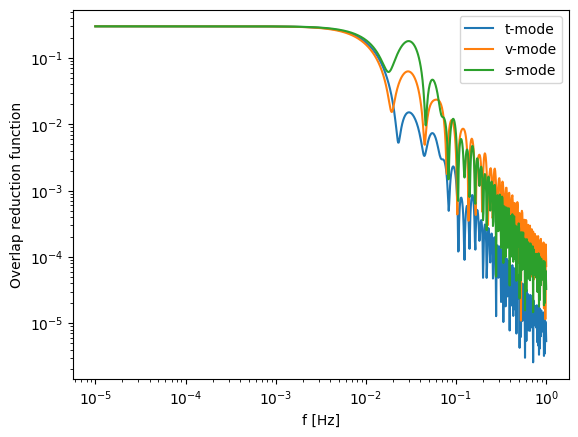

In [15]:
plt.semilogx(f, np.abs(response_auto[0]), label='t-mode')
plt.semilogx(f, np.abs(response_auto[1]), label='v-mode')
plt.semilogx(f, np.abs(response_auto[2]), label='s-mode')
plt.xlabel('f [Hz]')
plt.ylabel('Overlap reduction function')
plt.yscale('log')
plt.legend()

In [16]:
response_ABBC = overlap_all_f('AB', 'BC', f, 0, norm=False)
response_BCCA = overlap_all_f('BC', 'CA', f, 0, norm=False)
response_ABCA = overlap_all_f('AB', 'CA', f, 0, norm=False)


Computing t-mode:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_4277/4011784140.py:19: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  gamma_x = simps(f_values, x_values, axis=0)
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_4277/4011784140.py:20: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  gamma = simps(gamma_x, y_values)
Computing s-mode: 100%|██████████| 1000/1000 [00:05<00:00, 192.69it/s]


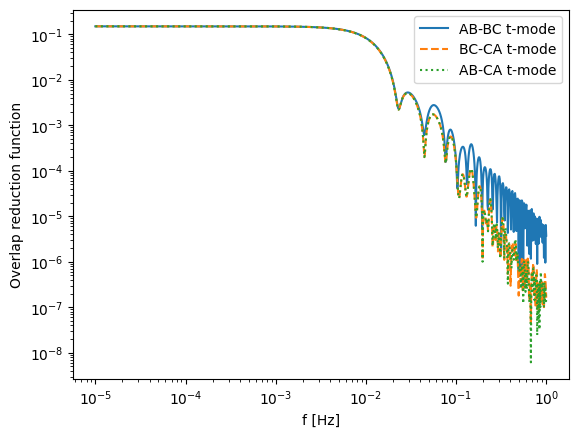

In [17]:
plt.plot(f, np.abs(response_ABBC[0]), label='AB-BC t-mode')
# plt.plot(f, response_ABBC[1], label='AB-BC v-mode')
# plt.plot(f, response_ABBC[2], label='AB-BC s-mode')
plt.plot(f, np.abs(response_BCCA[0]), label='BC-CA t-mode', linestyle='dashed')
# plt.plot(f, response_BCCA[1], label='BC-CA v-mode')
# plt.plot(f, response_BCCA[2], label='BC-CA s-mode')
plt.plot(f, np.abs(response_ABCA[0]), label='AB-CA t-mode', linestyle='dotted')
# plt.plot(f, response_ABCA[1], label='AB-CA v-mode')
# plt.plot(f, response_ABCA[2], label='AB-CA s-mode')
plt.xlabel('f [Hz]')
plt.ylabel('Overlap reduction function')
plt.legend()
plt.xscale('log')
plt.yscale('log')
